# GAN project with İbrahim artworks dataset

In [132]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import glob
import imageio
import math
from IPython import display
from PIL import Image

## Helper functions and helper variables

In [133]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def progress(i, size, status="Progress"):
    progress = i / size * 100
    progress = round(progress, 2)
    print("\r{}: {}%".format(status, progress), end="")

def select_random_image(images, row, col):
    fig, axes = plt.subplots(row, col, figsize=(row, col))
    for i in range(row):
        for j in range(col):
            img = images[np.random.randint(0, len(images) - 1)]
            axes[i, j].imshow(img / 255.0)
            axes[i, j].axis("off")
    plt.show()

## Arguments

### General Arguments

In [134]:
ART_DIR = "dataset/balaban_resim_cropped"

num_img = len(os.listdir(ART_DIR))

DATA_PATH = "data"
IMG_PATH = "train_images"

GENERATE_RES = 2
GENERATE_SQUARE = 32 * GENERATE_RES

IMAGE_CHANNELS = 3

PREVIEW_ROWS = 8
PREVIEW_COLS = 8
PREVIEW_MARGIN = 16
SAVE_FREQ = 2

SEED_SIZE = 100

### Image Augmentation Arguments (sample boosting)

In [143]:
SAMPLE_BOOST_SIZE = num_img * 10
ROTATION_RANGE = 20
WIDTH_SHIFT_RANGE = 0.5
HEIGHT_SHIFT_RANGE = 0.5
ZOOM_RANGE = 0.3
HORIZONTAL_FLIP = True
VERTICAL_FLIP = False
FILL_MODE = "nearest"
BRIGHTNESS_RANGE = [0.8,1.2]
SHEAR_RANGE = 0.05

### Preprocessing Arguments

In [144]:
MEDIAN_FILTER = False

GAUSIAN_FILTER = False

BILITERAL_FILTER = False

### Model Arguments

In [145]:
BATCH_SIZE = 8
EPOCHS = 100
BUFFER_SIZE = 60000
LR_RATE = 1.5e-4

### Name of the output files

In [146]:
total_num_img = num_img + SAMPLE_BOOST_SIZE


brightness_range = str(BRIGHTNESS_RANGE).replace("[", "").replace("]", "").replace(" ", "").replace(",", "_").replace(".", "")

shear_range = str(SHEAR_RANGE).replace(".", "")

TRAIN_IMAGE_NAME = "total_num_img_{}_fill_mode_{}_shear_range_{}_median_filter_{}_gausian_filter_{}_biliteral_filter_{}".format(
    total_num_img,
    ROTATION_RANGE,
    FILL_MODE,
    MEDIAN_FILTER,
    GAUSIAN_FILTER,
    BILITERAL_FILTER,
)

lr_rate = str(LR_RATE).replace(".", "")

ANIM_FILE_NAME = "image_res_{}_preview_rows_{}_preview_cols_{}_preview_margin_{}_save_freq_{}_batch_size_{}_epochs_{}_buffer_size_{}_lr_rate_{}".format(
    GENERATE_RES,
    PREVIEW_ROWS,
    PREVIEW_COLS,
    PREVIEW_MARGIN,
    SAVE_FREQ,
    BATCH_SIZE,
    EPOCHS,
    BUFFER_SIZE,
    lr_rate
)

#### Check names

In [147]:
print("Train image name:\n")
print(TRAIN_IMAGE_NAME)

print()

print("Animation file name:\n")
print(ANIM_FILE_NAME)


Train image name:

total_num_img_506_fill_mode_20_shear_range_nearest_median_filter_False_gausian_filter_False_biliteral_filter_False

Animation file name:

image_res_2_preview_rows_8_preview_cols_8_preview_margin_16_save_freq_2_batch_size_8_epochs_100_buffer_size_60000_lr_rate_000015


#### Test file name to see if it is valid

In [148]:

with open(ANIM_FILE_NAME+ ".txt", "w") as f:
    f.write(ANIM_FILE_NAME)

os.remove(ANIM_FILE_NAME+ ".txt")

with open(TRAIN_IMAGE_NAME+ ".txt", "w") as f:
    f.write(TRAIN_IMAGE_NAME)

os.remove(TRAIN_IMAGE_NAME+ ".txt")


## Filtering Functions

In [149]:
def median_filter(img):
    return cv2.medianBlur(img, ksize=3)

def gausian_filter(img):
    return cv2.GaussianBlur(img, ksize=(3, 3), sigmaX=0)

def biliteral_filter(img):
    return cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

## Image loading, preprocessing and image augmentation

In [150]:
if not os.path.exists(IMG_PATH):
    os.makedirs(IMG_PATH)


if not os.path.exists(IMG_PATH + "/" + TRAIN_IMAGE_NAME):
    
    for filename in os.listdir(IMG_PATH):
        os.remove(IMG_PATH + "/" + filename)

    images = np.empty((0, GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS))
    for filename in os.listdir(ART_DIR):
        
        img = tf.keras.utils.load_img(ART_DIR + "/" + filename)
        resized_img = img.resize((GENERATE_SQUARE, GENERATE_SQUARE))
        img_array = tf.keras.utils.img_to_array(resized_img)

        if MEDIAN_FILTER:
            img_array = median_filter(img_array)
        elif GAUSIAN_FILTER:
            img_array = gausian_filter(img_array)
        elif BILITERAL_FILTER:
            img_array = biliteral_filter(img_array)

        if img is not None:
            images = np.append(images, [img_array], axis=0)
        
        progress(len(images), num_img, status="Loading images")
    

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=ROTATION_RANGE,
        width_shift_range=WIDTH_SHIFT_RANGE,
        height_shift_range=HEIGHT_SHIFT_RANGE,
        horizontal_flip=HORIZONTAL_FLIP,
        vertical_flip=VERTICAL_FLIP,
        zoom_range=ZOOM_RANGE,
        fill_mode=FILL_MODE,
        brightness_range=BRIGHTNESS_RANGE,
        shear_range=SHEAR_RANGE,
    )


    imageIterator = datagen.flow(np.array(images), batch_size=1)


    for i in range(SAMPLE_BOOST_SIZE):
        aumented_img = imageIterator.next()
        images = np.append(images, aumented_img, axis=0)
        
        progress(i, SAMPLE_BOOST_SIZE, status="Boosting samples")
        

    print("\nNumber of images boosted:", SAMPLE_BOOST_SIZE)
    print("Number of actual images:", num_img)
    print("Number of images loaded:", len(images))
        
    np.save(IMG_PATH + "/" + TRAIN_IMAGE_NAME + ".npy", images)
    print("Images array saved!")

else:
    print("Samples already boosted!")
    
    images = np.load(IMG_PATH + "/" +  TRAIN_IMAGE_NAME + ".npy")
    
    print("Number of images boosted:", SAMPLE_BOOST_SIZE)
    print("Number of actual images:", num_img)
    print("Number of images loaded:", len(images))

Boosting samples: 99.78%
Number of images boosted: 460
Number of actual images: 46
Number of images loaded: 506
Images array saved!


## Plot 64 random images


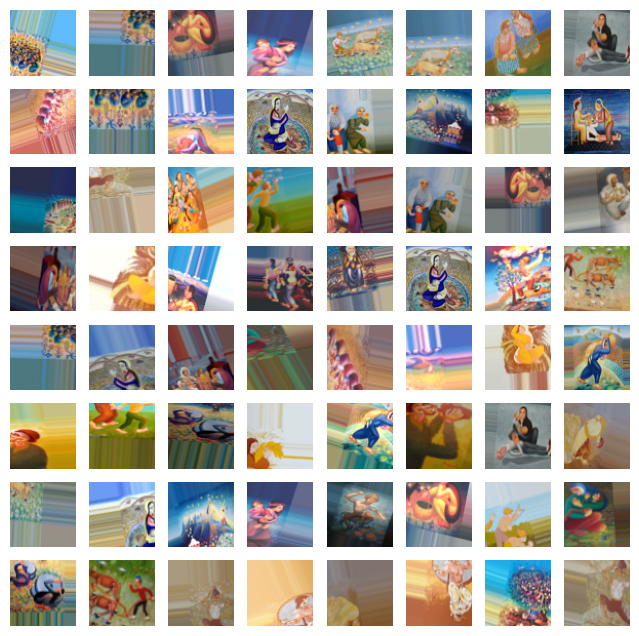

In [151]:


select_random_image(images, PREVIEW_ROWS, PREVIEW_COLS)


## Creating the training set

In [ ]:
training_data = np.array(images).reshape(-1, GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS)
training_data = training_data.astype("float32")
training_data = training_data / 127.5 - 1

training_data = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create generator function

In [ ]:
def build_generator(seed_size, channels):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(8*8*256,activation="relu",input_dim=seed_size))
    model.add(tf.keras.layers.Reshape((8,8,256)))

    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(256,kernel_size=3,padding="same"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Activation("relu"))

    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(128,kernel_size=3,padding="same"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Activation("relu"))

    if GENERATE_RES>1:
      model.add(tf.keras.layers.UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(tf.keras.layers.Conv2D(64,kernel_size=3,padding="same"))
      model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
      model.add(tf.keras.layers.Activation("relu"))

    # Final CNN layer
    model.add(tf.keras.layers.Conv2D(channels,kernel_size=3,padding="same"))
    model.add(tf.keras.layers.Activation("tanh"))

    return model

### Generator model summary

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)


generator.summary()

### Test generator model

In [ ]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Create discriminator function

In [ ]:
def build_discriminator(image_shape):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(512, kernel_size=3, strides=2, padding="same"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

### Summary of discriminator model

In [ ]:

image_shape = (GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)

discriminator.summary()



### Test discriminator model

In [ ]:

decision = discriminator(generated_image)
print (decision)

## Create image save helper function

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1
    
  output_path = DATA_PATH
  if not os.path.exists(output_path):
   os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

  plt.figure(figsize=(PREVIEW_COLS,PREVIEW_ROWS))
  plt.imshow(image_array, interpolation='nearest', cmap='gray')
  plt.tight_layout()
  plt.show()
          


## Define loss functions

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Define optimizers

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(LR_RATE,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(LR_RATE,0.5)

## Training step  (Semi-automatic GradientTape)

In [ ]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

## Training loop

In [ ]:
def train(dataset, epochs):
  gen_losses = []
  disc_losses = []
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    
    
    if (epoch+1) % SAVE_FREQ == 0 or epoch == 0:
      display.clear_output(wait=True)
      print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {hms_string(epoch_elapsed)}')
      save_images(epoch,fixed_seed)

    gen_losses.append(g_loss)
    disc_losses.append(d_loss)


  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

  return gen_losses, disc_losses

### Plot images again to compare with generated images

In [ ]:
select_random_image(images, PREVIEW_ROWS, PREVIEW_COLS)


## Start training

In [ ]:
gen_losses, disc_losses = train(training_data, EPOCHS)

In [ ]:
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Create GIF for training process

In [ ]:
anim_file = ANIM_FILE_NAME + '.gif'

images_data = []

with imageio.get_writer(anim_file, mode='I', fps=20) as writer:
    filenames = glob.glob(DATA_PATH + '/' +'*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

## Display training process

In [ ]:
import IPython
display.Image(filename=anim_file)
